# English Wikipedia Page Views by Topics in Septermber & August 2019


https://phabricator.wikimedia.org/T234839


In this analysis, we use Adam's topic dataset of articles with "best" topic prediction for pages accessed in September 2019. (see [example](https://dr0ptp4kt.github.io/topics-7.html) of first 10K non-randomized rows for an HTML view). 

The outcome topics are from the "predicted" field, which is the post-enrichment best guess for the articels.


In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this notebook is by default hidden for easier reading.
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code"></form>
''')

In [2]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import gzip
from wmfdata import hive
import numpy as np

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [3]:
##read topic prediction file
topic = pd.read_csv('topic_prediction.tsv.gz', sep='\t',compression='gzip', header=0)

In [4]:
pageview_query = '''
    SELECT 
        CONCAT(year,"-",month,"-01") AS date,
        page_id, 
        SUM(view_count) AS pageviews
    FROM 
        wmf.pageview_hourly
    WHERE year = "{year}"
        AND month = "{month}" 
        AND project = "{wiki}"
        AND namespace_id = 0
        AND agent_type = "user"
        AND NOT (
            country_code IN ("PK", "IR", "AF") 
            AND user_agent_map["browser_family"] = "IE" AND user_agent_map["browser_major"] = 7
        )
    GROUP BY CONCAT(year,"-",month,"-01"), page_id
'''

## September 2019 Topic Analysis 

In [13]:
enwiki_pv_sept_all = hive.run([
    "SET mapreduce.map.memory.mb=4096",    
     pageview_query.format(
        year = 2019,
        month = 9,
        wiki = "en.wikipedia")
])

In [6]:
enwiki_pv_sept_all['proportion']= enwiki_pv_sept_all['pageviews']/enwiki_pv_sept_all['pageviews'].sum()
enwiki_pv_sep_all = enwiki_pv_sept_all.sort_values(by='pageviews', ascending=False)

In [7]:
enwiki_pv_sept_all[enwiki_pv_sept.page_id.isnull()]

,date,page_id,pageviews,proportion
4156974,2019-9-01,NaN,48039,0.000007


In [70]:
print('Total page views in September: ' + str(enwiki_pv_sept_all.pageviews.sum()))

Total page views: 7198970305


In [71]:
print('Number of unqiue pages in September: ' + str(enwiki_pv_sept_all.shape[0]))

Number of unqiue pages: 8043636


In [11]:
print('Top 1M pages account for ' + str(round(enwiki_pv_sept_all.proportion[:1000000].sum() * 100,2)) + '% of total page views in September.')

Top 1M pages account for 91.8% of total page views.


In [50]:
pageview_title_query = '''
WITH v AS (
    SELECT page_id, SUM(view_count) AS pageviews
    FROM wmf.pageview_hourly
    WHERE year = "{year}"
        AND month = "{month}" 
        AND project = "{wiki}"
        AND namespace_id = 0
        AND agent_type = "user"
        AND NOT (
            country_code IN ("PK", "IR", "AF") AND user_agent_map["browser_family"] = "IE" AND user_agent_map["browser_major"] = 7
        )
    GROUP BY page_id
    LIMIT 10000000
), p AS (
    SELECT page_id, page_title, page_latest
    FROM wmf_raw.mediawiki_page
    WHERE wiki_db = "enwiki"
    AND snapshot = "{snapshot}"
    AND page_id IS NOT NULL
    AND page_namespace = 0
    AND NOT page_is_redirect
)

SELECT v.page_id, p.page_title, v.pageviews
FROM v LEFT JOIN p ON v.page_id=p.page_id
'''

In [51]:
enwiki_pv_sept = hive.run([
    "SET mapreduce.map.memory.mb=4096",    
     pageview_title_query.format(
        year = 2019,
        month = 9,
        wiki = "en.wikipedia",
        snapshot = "2019-09")
])

In [52]:
enwiki_pv_sept['proportion']= enwiki_pv_sept['pageviews']/enwiki_pv_sept['pageviews'].sum()
enwiki_pv_sept = enwiki_pv_sept.sort_values(by='pageviews', ascending=False)

In [56]:
enwiki_pv_topic_sept = enwiki_pv_sept.merge(topic, how = 'left', on = 'page_id')

In [57]:
enwiki_pv_topic_sept['predicted'] = enwiki_pv_topic_sept['predicted'].fillna(value='Unknown')
enwiki_pv_topic_sept['proportion']= enwiki_pv_topic_sept['pageviews']/enwiki_pv_topic_sept['pageviews'].sum()

### Top 50 articles read in September 2019 on English Wikipedia¶

The table below shows the top 50 articles viewed in English Wikipedia in September 2019, with the corresponding propotions among the total pageviews and the best predicted topic.

In [59]:
enwiki_page_sept_summary = enwiki_pv_topic_sept[['page_title','pageviews','proportion','predicted']].sort_values(by='pageviews', ascending=False).reset_index(drop=True).head(50)


In [60]:
print('Top 50 articles account for ' +  str(round(enwiki_page_sept_summary.proportion.sum() * 100,2))+ '% of total page views in September.')

Top 50 articles account for 7.84% of total page views in September.


In [61]:
enwiki_page_sept_summary

,page_title,pageviews,proportion,predicted
0,Main_Page,473316359,0.065746,Internet culture
1,Wikipedia,7376833,0.001025,Language and literature
2,List_of_Queen_of_the_South_episodes,6426243,0.000893,Broadcasting
3,It_Chapter_Two,3777663,0.000525,Entertainment
4,Deaths_in_2019,3225335,0.000448,Time
5,Greta_Thunberg,3146905,0.000437,History and society
6,Saaho,2927278,0.000407,Entertainment
7,Joker_(2019_film),2864258,0.000398,Visual arts
8,September_11_attacks,2435866,0.000338,Politics and government
9,Antonio_Brown,2359216,0.000328,Sports


### September Top 50 Topics Viewed


The table below shows the page views by top 50 topics in September 2019 on English Wikipedia. Main page is excluded in this table.

In [65]:
enwiki_topic_sept_summary = (enwiki_pv_topic_sept[enwiki_pv_topic_sept.page_title != 'Main_Page']
          .groupby('predicted', as_index = False)['pageviews', 'proportion']
          .sum()
          .sort_values(by='pageviews', ascending=False))

In [66]:
print('Top 10 topics account for ' +  str(round(enwiki_topic_sept_summary.proportion[:10].sum() * 100,2))+ '% of total page views in September.')
print('Top 50 topics account for ' +  str(round(enwiki_topic_sept_summary.proportion[:50].sum() * 100,2))+ '% of total page views in September.')

Top 10 topics account for 62.49% of total page views in September.
Top 50 topics account for 92.03% of total page views in September.


In [67]:
enwiki_topic_sept_summary.head(50)

,predicted,pageviews,proportion
148,Entertainment,951015501,0.132101
424,Sports,651186372,0.090453
339,Performing arts,582187240,0.080869
75,Broadcasting,508963501,0.070698
202,History and society,490649682,0.068154
347,Politics and government,390908702,0.054299
245,Language and literature,233216220,0.032395
446,Technology,233007905,0.032366
83,Business and economics,228801818,0.031782
342,Philosophy and religion,228716606,0.031770


## September & August 2019 Topic Data Comparison

In [72]:
enwiki_pv_aug_all = hive.run([
    "SET mapreduce.map.memory.mb=4096",    
     pageview_query.format(
        year = 2019,
        month = 8,
        wiki = "en.wikipedia")
])

In [73]:
enwiki_pv_aug_all['proportion']= enwiki_pv_aug_all['pageviews']/enwiki_pv_aug_all['pageviews'].sum()
enwiki_pv_aug_all = enwiki_pv_aug_all.sort_values(by='pageviews', ascending=False)

In [74]:
print('Total page views in August: ' + str(enwiki_pv_aug_all.pageviews.sum()))

Total page views in August: 7212202447


In [76]:
print('Number of unqiue pages in August: ' + str(enwiki_pv_aug_all.shape[0]))

Number of unqiue pages in August: 8813929


In [69]:
enwiki_pv_aug = hive.run([
    "SET mapreduce.map.memory.mb=4096",    
     pageview_title_query.format(
        year = 2019,
        month = 8,
        wiki = "en.wikipedia",
        snapshot = "2019-09")
])

In [77]:
enwiki_pv_topic_aug = enwiki_pv_aug.merge(topic, how = 'left', on = 'page_id')

In [79]:
enwiki_pv_topic_aug['predicted'] = enwiki_pv_topic_aug['predicted'].fillna(value='Unknown')
enwiki_pv_topic_aug['proportion']= enwiki_pv_topic_aug['pageviews']/enwiki_pv_topic_aug['pageviews'].sum()

### August Top 50 Topics Viewed

In [83]:
enwiki_topic_aug_summary = (enwiki_pv_topic_aug[enwiki_pv_topic_aug.page_title != 'Main_Page']
          .groupby('predicted', as_index = False)['pageviews', 'proportion']
          .sum()
          .sort_values(by='pageviews', ascending=False))

In [84]:
print('Top 10 topics account for ' +  str(round(enwiki_topic_aug_summary.proportion[:10].sum() * 100,2))+ '% of total page views in August')
print('Top 50 topics account for ' +  str(round(enwiki_topic_aug_summary.proportion[:50].sum() * 100,2))+ '% of total page views in August')

Top 10 topics account for 62.48% of total page views in August
Top 50 topics account for 91.99% of total page views in August


In [85]:
enwiki_topic_sept_summary.head(50)

,predicted,pageviews,proportion
148,Entertainment,951015501,0.132101
424,Sports,651186372,0.090453
339,Performing arts,582187240,0.080869
75,Broadcasting,508963501,0.070698
202,History and society,490649682,0.068154
347,Politics and government,390908702,0.054299
245,Language and literature,233216220,0.032395
446,Technology,233007905,0.032366
83,Business and economics,228801818,0.031782
342,Philosophy and religion,228716606,0.031770


### Top Topics Rank Comparison September vs. August

In [86]:
enwiki_topic_sept_summary["sept_rank"] = enwiki_topic_sept_summary["proportion"].rank(ascending=0) 
enwiki_topic_aug_summary["aug_rank"] = enwiki_topic_aug_summary["proportion"].rank(ascending=0) 

In [87]:
topic_rank = enwiki_topic_sept_summary.merge(enwiki_topic_aug_summary, how = 'left', on = 'predicted')
topic_rank = topic_rank.rename(columns={'predicted': 'topic', 'proportion_x': 'proportion_sept','proportion_y': 'proportion_aug','pageviews_x':'pageviews_sept','pageviews_y':'pageviews_aug'})

In [88]:
topic_rank[['topic','proportion_sept','proportion_aug','sept_rank','aug_rank']].head(50)


,topic,proportion_sept,proportion_aug,sept_rank,aug_rank
0,Entertainment,0.132101,0.138937,1.0,1.0
1,Sports,0.090453,0.087186,2.0,2.0
2,Performing arts,0.080869,0.081190,3.0,3.0
3,Broadcasting,0.070698,0.071853,4.0,4.0
4,History and society,0.068154,0.069659,5.0,5.0
5,Politics and government,0.054299,0.052139,6.0,6.0
6,Language and literature,0.032395,0.032178,7.0,7.0
7,Technology,0.032366,0.030678,8.0,9.0
8,Business and economics,0.031782,0.030793,9.0,8.0
9,Philosophy and religion,0.031770,0.030154,10.0,11.0


The changes in proportion and rank between September and August for top 50 topics are not very noticeable. 

In [89]:
topic_rank['rank_diff_abs'] = abs(topic_rank['sept_rank'] - topic_rank['aug_rank'])


In [91]:
topic_rank[['topic','proportion_sept','proportion_aug','sept_rank','aug_rank','rank_diff_abs']].head(100).sort_values(by='rank_diff_abs', ascending=False).head(10)


,topic,proportion_sept,proportion_aug,sept_rank,aug_rank,rank_diff_abs
59,The_Bahamas,0.000239,0.000022,60.0,196.0,136.0
99,Hong_Kong,0.000074,0.000156,100.0,73.0,27.0
78,predicted,0.000133,0.000104,79.0,89.0,10.0
73,Netherlands,0.000147,0.000127,74.0,82.0,8.0
76,Syria,0.000139,0.000120,77.0,85.0,8.0
28,Meteorology,0.003144,0.002263,29.0,35.0,6.0
69,Israel,0.000164,0.000146,70.0,76.0,6.0
84,Denmark,0.000105,0.000138,85.0,79.0,6.0
94,Saudi Arabia,0.000088,0.000075,95.0,101.0,6.0
86,Argentina,0.000104,0.000100,87.0,92.0,5.0


By looking at top 10 topics change in rank from Auguat to September, the topics related to "Country/Region" changes the most between two month.

### Top Topics Pageviews Comparison September vs. August

Compare changes in pageviews for top 10 topics between Spetember and August 2019.

In [92]:
## Load the RPython library so we can use R for graphs

%load_ext rpy2.ipython

In [97]:
%%R
library(ggplot2)
library (tidyverse)
library(data.table)

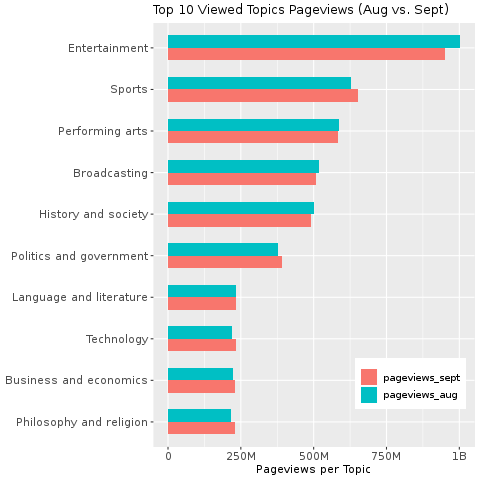

In [98]:
%%R -i topic_rank

data.table(topic_rank)[1:10] %>%
    melt(id.vars = c("topic"), measure.vars = c("pageviews_sept", "pageviews_aug"),variable.name = "month", value.name = 'count') %>%
    ggplot(aes(fill=month, y=count, x=reorder(topic,count))) + 
    geom_bar(position="dodge", stat="identity",width = 0.6) + coord_flip() +
    scale_y_continuous("Pageviews per Topic",
                       labels = polloi::compress) +
    theme(axis.title.y=element_blank(),
          axis.text=element_text(size=11),
          legend.position = c(0.8, 0.15), legend.title = element_blank(),legend.text =element_text( hjust = 0,size = 10))+
    labs(color = "type",
         title = "Top 10 Viewed Topics Pageviews (Aug vs. Sept)")


Compare topics with top 10 changes in pageview percentage between Spetember and August 2019.

In [99]:
topic_rank['pv_diff_pct'] = abs(topic_rank['pageviews_aug'] / topic_rank['pageviews_sept']-1)


In [103]:
pv_diff = topic_rank[['topic','pageviews_sept','pageviews_aug','pv_diff_pct']].head(50).sort_values(by='pv_diff_pct', ascending=False).head(10)


/home/conniecc1/venv/lib/python3.5/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


TypeError: unsupported operand type(s) for &: 'list' and 'list'

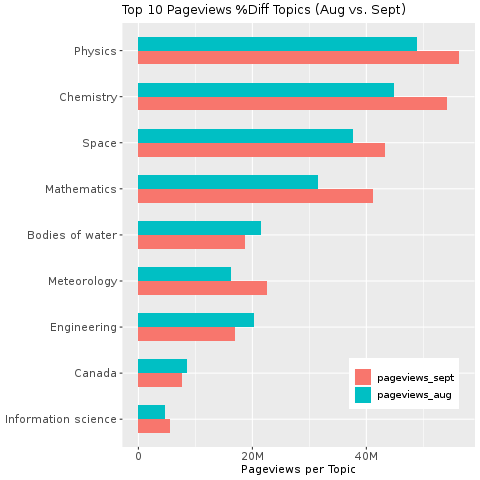

In [104]:
%%R -i pv_diff

data.table(pv_diff) %>%
    filter(topic != 'Unknown') %>%
    melt(id.vars = c("topic"), measure.vars = c("pageviews_sept", "pageviews_aug"),variable.name = "month", value.name = 'count') %>%
    ggplot(aes(fill=month, y=count, x=reorder(topic,count))) + 
    geom_bar(position="dodge", stat="identity",width = 0.6) + coord_flip() +
    scale_y_continuous("Pageviews per Topic",
                       labels = polloi::compress) +
    theme(axis.title.y=element_blank(),
          axis.text=element_text(size=11),
          legend.position = c(0.8, 0.15), legend.title = element_blank(),legend.text =element_text( hjust = 0,size = 10))+
    labs(color = "type",
         title = "Top 10 Pageviews %Diff Topics (Aug vs. Sept)")
